<a href="https://colab.research.google.com/github/seojihyuk26/EarthquakePredictor/blob/main/earthquakePredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 모듈 로드

In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.9.2
Hub version: 0.12.0
GPU is NOT AVAILABLE


In [2]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
  # raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [149]:
import pandas as pd
from datetime import timedelta

In [4]:
import folium
print("folium version:", folium.__version__)

folium version: 0.12.1.post1


In [5]:
from folium import plugins

In [109]:
from tensorflow.keras.layers import LSTM, Dense, Attention, concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras import losses,layers
from tensorflow.keras.callbacks import EarlyStopping, TerminateOnNaN
import tensorflow.keras as keras

In [7]:
import matplotlib.pyplot as plt

In [8]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

In [9]:
from tensorflow.keras.utils import plot_model

In [64]:
%load_ext tensorboard

# 데이터 입력

In [315]:
data = pd.read_csv('https://raw.githubusercontent.com/seojihyuk26/EarthquakePredictor/main/earthquake1900.csv')
data

time  latitude  longitude   depth   mag
0      2022-12-28T16:34:20.446Z  -21.2622   171.3631  10.000  6.00
1      2022-12-20T10:34:24.770Z   40.5250  -124.4230  17.910  6.37
2      2022-12-14T18:40:26.902Z   51.6382   178.6190  73.000  6.30
3      2022-12-14T18:40:26.778Z   51.6199   178.6159  73.000  6.30
4      2022-12-11T14:31:29.703Z   17.2565  -100.4369  18.346  6.00
...                         ...       ...        ...     ...   ...
13818  1902-11-17T19:50:00.000Z   37.4000  -113.5000     NaN  6.30
13819  1902-01-01T05:20:30.000Z   52.3800  -167.4500     NaN  7.00
13820  1901-12-31T09:02:30.000Z   51.4500  -171.0200     NaN  7.10
13821  1901-12-30T22:34:00.000Z   52.0000  -160.0000     NaN  7.00
13822  1901-03-03T07:45:00.000Z   36.0000  -120.5000     NaN  6.40

[13823 rows x 5 columns]

In [316]:
print(data.info())
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13823 entries, 0 to 13822
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       13823 non-null  object 
 1   latitude   13823 non-null  float64
 2   longitude  13823 non-null  float64
 3   depth      13771 non-null  float64
 4   mag        13823 non-null  float64
dtypes: float64(4), object(1)
memory usage: 540.1+ KB
None
(13823, 5)


# 데이터 전처리

In [317]:
data = data.fillna(data.mean())
data

<ipython-input-317-e8d3a8cf2ef0>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data = data.fillna(data.mean())


time  latitude  longitude      depth   mag
0      2022-12-28T16:34:20.446Z  -21.2622   171.3631  10.000000  6.00
1      2022-12-20T10:34:24.770Z   40.5250  -124.4230  17.910000  6.37
2      2022-12-14T18:40:26.902Z   51.6382   178.6190  73.000000  6.30
3      2022-12-14T18:40:26.778Z   51.6199   178.6159  73.000000  6.30
4      2022-12-11T14:31:29.703Z   17.2565  -100.4369  18.346000  6.00
...                         ...       ...        ...        ...   ...
13818  1902-11-17T19:50:00.000Z   37.4000  -113.5000  56.177293  6.30
13819  1902-01-01T05:20:30.000Z   52.3800  -167.4500  56.177293  7.00
13820  1901-12-31T09:02:30.000Z   51.4500  -171.0200  56.177293  7.10
13821  1901-12-30T22:34:00.000Z   52.0000  -160.0000  56.177293  7.00
13822  1901-03-03T07:45:00.000Z   36.0000  -120.5000  56.177293  6.40

[13823 rows x 5 columns]

In [318]:
data = data.iloc[::-1]
data

time  latitude  longitude      depth   mag
13822  1901-03-03T07:45:00.000Z   36.0000  -120.5000  56.177293  6.40
13821  1901-12-30T22:34:00.000Z   52.0000  -160.0000  56.177293  7.00
13820  1901-12-31T09:02:30.000Z   51.4500  -171.0200  56.177293  7.10
13819  1902-01-01T05:20:30.000Z   52.3800  -167.4500  56.177293  7.00
13818  1902-11-17T19:50:00.000Z   37.4000  -113.5000  56.177293  6.30
...                         ...       ...        ...        ...   ...
4      2022-12-11T14:31:29.703Z   17.2565  -100.4369  18.346000  6.00
3      2022-12-14T18:40:26.778Z   51.6199   178.6159  73.000000  6.30
2      2022-12-14T18:40:26.902Z   51.6382   178.6190  73.000000  6.30
1      2022-12-20T10:34:24.770Z   40.5250  -124.4230  17.910000  6.37
0      2022-12-28T16:34:20.446Z  -21.2622   171.3631  10.000000  6.00

[13823 rows x 5 columns]

In [320]:
data.dtypes

time                         float64
latitude                     float64
longitude                    float64
depth                        float64
mag                          float64
original_time    datetime64[ns, UTC]
dtype: object

In [319]:
# Convert the time column to datetime
data['time'] = pd.to_datetime(data['time'])
data['original_time'] = data['time']#pd.Timestamp.to_datetime64()

# Calculate the time difference between each time step
data['time'] = data['time'].dt.date.diff().dt.days

data.loc[data.shape[0]-1,"time"] = 0

data

time  latitude  longitude      depth   mag  \
13822    0.0   36.0000  -120.5000  56.177293  6.40   
13821  302.0   52.0000  -160.0000  56.177293  7.00   
13820    1.0   51.4500  -171.0200  56.177293  7.10   
13819    1.0   52.3800  -167.4500  56.177293  7.00   
13818  320.0   37.4000  -113.5000  56.177293  6.30   
...      ...       ...        ...        ...   ...   
4        7.0   17.2565  -100.4369  18.346000  6.00   
3        3.0   51.6199   178.6159  73.000000  6.30   
2        0.0   51.6382   178.6190  73.000000  6.30   
1        6.0   40.5250  -124.4230  17.910000  6.37   
0        8.0  -21.2622   171.3631  10.000000  6.00   

                         original_time  
13822        1901-03-03 07:45:00+00:00  
13821        1901-12-30 22:34:00+00:00  
13820        1901-12-31 09:02:30+00:00  
13819        1902-01-01 05:20:30+00:00  
13818        1902-11-17 19:50:00+00:00  
...                                ...  
4     2022-12-11 14:31:29.703000+00:00  
3     2022-12-14 18:40:26.778000+00:00  
2     2022-12-14 18:40:26.902000+00:00  
1     2022-12-20 10:34:24.770000+00:00  
0     2022-12-28 16:34:20.446000+00:00  

[13823 rows x 6 columns]

In [217]:
class DivideColumns(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1, columns=None):
        self.factor = factor
        self.columns = columns
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        cols_to_transform = list(X.columns)

        if self.columns:
            cols_to_transform = self.columns

        X[cols_to_transform] = X[cols_to_transform] / self.factor
        return X

    def inverse_transform(self, X, y=None):
        cols_to_transform = list(X.columns)

        if self.columns:
            cols_to_transform = self.columns

        X[cols_to_transform] = X[cols_to_transform] * self.factor
        return X

In [218]:
class FixedMinMaxScaler(BaseEstimator, TransformerMixin):
    def __init__(self, min=0, columns=None):
        self.min = min
        self.columns = columns
        self.length = 1
    
    def fit(self, X, y=None):
        cols_to_transform = list(X.columns)

        if self.columns:
            cols_to_transform = self.columns
        if X[cols_to_transform].max()[0]-self.min <= 0:
            self.length = 0.0000001
        else:
            self.length = X[cols_to_transform].max()[0]-self.min
        return self

    def transform(self, X, y=None):
        cols_to_transform = list(X.columns)

        if self.columns:
            cols_to_transform = self.columns
        X[cols_to_transform] = (X[cols_to_transform] - self.min)/self.length
        return X

    def inverse_transform(self, X, y=None):
        cols_to_transform = list(X.columns)

        if self.columns:
            cols_to_transform = self.columns

        X[cols_to_transform] = X[cols_to_transform]*self.length + self.min
        return X

In [219]:
pipe = ColumnTransformer(transformers=[
    ("time", FixedMinMaxScaler(),["time"]),
    ("latitude", DivideColumns(90),["latitude"]),
    ("longitude", DivideColumns(180),["longitude"]),
    ("depth", FixedMinMaxScaler(),["depth"]),
    ("mag", FixedMinMaxScaler(6),["mag"]),
    ('original_time', 'passthrough',["original_time"])
])
data_scaled = pipe.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, index=data.index, columns=data.columns)
data_scaled

time  latitude longitude     depth       mag  \
13822       0.0       0.4 -0.669444  0.081653  0.114286   
13821   0.94375  0.577778 -0.888889  0.081653  0.285714   
13820  0.003125  0.571667 -0.950111  0.081653  0.314286   
13819  0.003125     0.582 -0.930278  0.081653  0.285714   
13818       1.0  0.415556 -0.630556  0.081653  0.085714   
...         ...       ...       ...       ...       ...   
4      0.021875  0.191739 -0.557983  0.026666       0.0   
3      0.009375  0.573554  0.992311  0.106105  0.085714   
2           0.0  0.573758  0.992328  0.106105  0.085714   
1       0.01875  0.450278 -0.691239  0.026032  0.105714   
0         0.025 -0.236247  0.952017  0.014535       0.0   

                         original_time  
13822        1901-03-03 07:45:00+00:00  
13821        1901-12-30 22:34:00+00:00  
13820        1901-12-31 09:02:30+00:00  
13819        1902-01-01 05:20:30+00:00  
13818        1902-11-17 19:50:00+00:00  
...                                ...  
4     2022-12-11 14:31:29.703000+00:00  
3     2022-12-14 18:40:26.778000+00:00  
2     2022-12-14 18:40:26.902000+00:00  
1     2022-12-20 10:34:24.770000+00:00  
0     2022-12-28 16:34:20.446000+00:00  

[13823 rows x 6 columns]

In [220]:
data = data_scaled

In [221]:
data.isnull().any()

time             False
latitude         False
longitude        False
depth            False
mag              False
original_time    False
dtype: bool

In [418]:
def seq2dataset(seq, window_size):
    dataset = []
    # print(seq.dtypes)
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append(subset)
    # print(dataset.dtype)
    return np.array(dataset)

In [223]:
timesteps = 10
startIndex = 1000
learningIndex = 2000
dataset = seq2dataset(data.iloc[startIndex:learningIndex,:5], timesteps)
X_train = dataset[:,0:timesteps]
y_train = dataset[:,timesteps]

In [383]:
data_scaled.iloc[learningIndex+10000]

time                          1970-01-01 00:00:00
latitude                                -0.200644
longitude                               -0.391928
depth                                    0.053779
mag                                      0.057143
original_time    2010-05-06 02:42:47.940000+00:00
Name: 1822, dtype: object

In [224]:
#X_train[0:3]

array([[[0.034375, -0.03386666666666667, 0.7705, 0.050872093023255814,
         0.21714285714285708],
        [0.00625, 0.5069444444444444, 0.8303499999999999,
         0.02180232558139535, 0.04857142857142855],
        [0.00625, 0.33976666666666666, 0.5020944444444444,
         0.02180232558139535, 0.04285714285714296],
        [0.003125, -0.14137777777777777, 0.9274722222222221,
         0.050872093023255814, 0.2914285714285713],
        [0.03125, 0.07634444444444445, -0.4582444444444444,
         0.02180232558139535, 0.0028571428571427964],
        [0.040625, 0.07938888888888888, 0.7047166666666667,
         0.050872093023255814, 0.23142857142857132],
        [0.0125, 0.0828, 0.7063944444444444, 0.02180232558139535,
         0.41142857142857153],
        [0.00625, 0.13143333333333335, -0.3969944444444445,
         0.02180232558139535, 0.0999999999999999],
        [0.00625, 0.4026222222222222, 0.3926333333333334,
         0.3488372093023256, 0.5142857142857142],
        [0.04375, -0.

In [225]:
#y_train[0:3]

array([[0.00625, 0.3453555555555556, 0.6650611111111111,
        0.02180232558139535, 0.17714285714285719],
       [0.021875, 0.3982555555555556, 0.7794111111111112,
        0.0872093023255814, 0.12285714285714278],
       [0.03125, -0.043533333333333334, -0.3973333333333333,
        0.7848837209302325, 0.3714285714285714]], dtype=object)

In [226]:
print("input data shape : ", X_train.shape, ", result shape: ", y_train.shape)

input data shape :  (990, 10, 5) , result shape:  (990, 5)


In [436]:
dataset_test = seq2dataset(data[learningIndex:], timesteps)
X_test = dataset_test[:,0:timesteps]
y_test = dataset_test[:,timesteps]
y_test = tf.convert_to_tensor(y_test[:,:5], tf.float32)
# y_test = y_test.numpy()

In [229]:
X_test[0:3]

array([[[0.009375, 0.18318888888888887, -0.5392555555555556,
         0.036337209302325583, 0.02000000000000008,
         Timestamp('1931-05-16 20:47:38.590000+0000', tz='UTC')],
        [0.0125, 0.41935555555555554, -0.08980555555555556,
         0.014534883720930232, 0.3485714285714285,
         Timestamp('1931-05-20 02:22:51.870000+0000', tz='UTC')],
        [0.0, -0.3229666666666667, -0.4030111111111111,
         0.02180232558139535, 0.03142857142857152,
         Timestamp('1931-05-20 21:53:53.780000+0000', tz='UTC')],
        [0.0125, 0.11407777777777778, 0.6978666666666666,
         0.02180232558139535, 0.02857142857142847,
         Timestamp('1931-05-24 00:13:06.110000+0000', tz='UTC')],
        [0.01875, 0.5800000000000001, 0.9627777777777778,
         0.08165304279468313, 0.0,
         Timestamp('1931-05-30 11:34:16+0000', tz='UTC')],
        [0.00625, -0.05793333333333334, 0.8436444444444444,
         0.050872093023255814, 0.06285714285714279,
         Timestamp('1931-06-01 1

In [230]:
y_test[0:3]

array([[ 0.0125    ,  0.39617777,  0.7748778 ,  0.05087209,  0.03714286],
       [ 0.015625  , -0.4252111 , -0.9999389 ,  0.02180232,  0.01714286],
       [ 0.003125  ,  0.40265554,  0.78734446,  0.03633721,  0.12857144]],
      dtype=float32)

In [322]:
print("input data shape : ", X_test.shape, ", result shape: ", y_test.shape)

input data shape :  (11813, 10, 6) , result shape:  (11813, 5)


# lstm 모델

In [141]:
# Assume that your input data has shape (batch_size, timesteps, input_dim)
input_dim = 5
output_dim = 5
batch_size = 1
LSTM_layer = []
with tf.device('/device:GPU:0'):
  inputs = keras.Input(shape=(timesteps, input_dim),batch_size=batch_size) #batch_size
  # inputsDense = Dense(5)(inputs)
  # model = Sequential()
  LSTM_layer.append(LSTM(64,stateful=True)(inputs)) #kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.00001, seed=7)  , input_shape=(batch_size,timesteps, input_dim)
  # LSTM_layer.append(LSTM(64, return_sequences=True, stateful=True)(LSTM_layer[-1])) #kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.00001, seed=7)  , input_shape=(batch_size,timesteps, input_dim)
  # model.add(Attention())
  # model.add(LSTM(64,stateful=True))
  # model.add(Dense(output_dim))
  time = Dense(1,activation='sigmoid', name="time")(LSTM_layer[-1])
  position = Dense(2, name="position")(LSTM_layer[-1])
  depth = Dense(1,activation='sigmoid', name="depth")(LSTM_layer[-1])
  mag = Dense(1, name="mag")(LSTM_layer[-1])
  outputs = concatenate([time, position,depth,mag])

  model = keras.Model(
    inputs=[inputs],
    outputs=[outputs],
)

model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(1, 10, 5)]         0           []                               
                                                                                                  
 lstm_26 (LSTM)                 (1, 64)              17920       ['input_27[0][0]']               
                                                                                                  
 time (Dense)                   (1, 1)               65          ['lstm_26[0][0]']                
                                                                                                  
 position (Dense)               (1, 2)               130         ['lstm_26[0][0]']                
                                                                                            

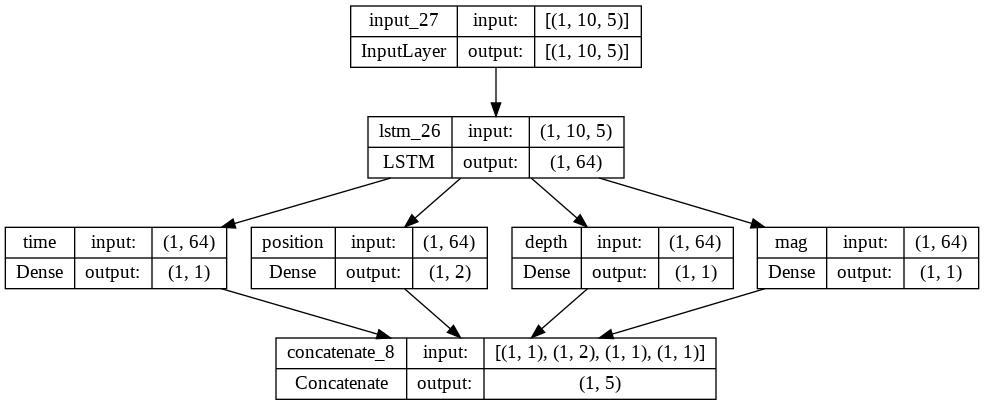

In [142]:
plot_model(model, to_file='model_shapes.png', show_shapes=True)

In [50]:
def degrees_to_radians(deg):
    return np.pi*deg/180

def sphericalToOrthogonal(lat,lon):
  x = tf.math.cos(lat)*tf.math.cos(lon)
  y = tf.math.cos(lat)*tf.math.sin(lon)
  z = tf.math.sin(lat)
  return tf.concat([x,y,z],0)

In [51]:
def haversine_distance_loss(lat1,lon1,lat2,lon2):
    
    # 위도와 경도의 단위를 라디안으로 변환
    lat1 = degrees_to_radians(lat1*90)
    lon1 = degrees_to_radians(lon1*180)
    lat2 = degrees_to_radians(lat2*90)
    lon2 = degrees_to_radians(lon2*180)
    
    p_1 = sphericalToOrthogonal(lat1,lon1)
    p_2 = sphericalToOrthogonal(lat2,lon2)
    
    # 유클리드 거리 공식 사용
    ThreeDimensionalDistance = tf.norm(p_1-p_2)
    
    # 거리의 제곱을 반환
    return (2*tf.math.asin(ThreeDimensionalDistance/2))**2/(np.pi**2)


In [52]:
# haversine_distance_loss(0,1,0.1,0.2)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6314963>

In [146]:
def custom_loss_function(y_true, y_pred):
    # 위도와 경도는 지구 위의 2개의 점 사이의 거리를 측정하는 커스텀 손실 함수
    distance_loss = haversine_distance_loss(y_true[:, 1], y_true[:, 2], y_pred[:, 1], y_pred[:, 2])
    # 나머지 파라미터는 평균 제곱 오차를 측정하는 함수
    true_time, true_depth, true_mag = y_true[:, 0], y_true[:, 3], y_true[:, 4]
    pred_time, pred_depth, pred_mag = y_pred[:, 0], y_pred[:, 3], y_pred[:, 4]
    
    # Calculate the mean squared error loss for the time, depth, and mag dimensions
    mse_loss = (true_time - pred_time)**2 + (true_depth - pred_depth)**2 + (true_mag - pred_mag)**2

    # mse_loss = losses.mean_squared_error(tf.gather(y_true, [0, 3, 4], axis=1), tf.gather(y_pred, [0, 3, 4], axis=1))
    # 커스텀 손실 함수 결과 반환
    return distance_loss + mse_loss


In [56]:
# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        self.accuracys = []
        self.term = TerminateOnNaN()
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracys.append(logs.get('acc'))
        self.term.on_epoch_end(batch, logs)

In [58]:
history = LossHistory() # 손실 이력 객체 생성

history.init()

In [59]:
import datetime
log_dir = "logs/my_board/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [147]:
with tf.device('/device:GPU:0'):
  model.compile(loss=custom_loss_function, optimizer="adam")#tf.keras.optimizers.Adam(learning_rate=0.0001)

# 모델 훈련

In [136]:
#term = TerminateOnNaN()

In [148]:
with tf.device('/device:GPU:0'):
  num_epochs = 100
  
  for epoch_idx in range(num_epochs):
      print ('epochs : ' + str(epoch_idx) )
      model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=2, shuffle=False, callbacks=[history]) #term
      model.reset_states()
    

epochs : 0
990/990 - 7s - loss: 0.1924 - 7s/epoch - 8ms/step
epochs : 1
990/990 - 4s - loss: 0.1857 - 4s/epoch - 4ms/step
epochs : 2
990/990 - 5s - loss: 0.1841 - 5s/epoch - 5ms/step
epochs : 3
990/990 - 5s - loss: 0.1833 - 5s/epoch - 5ms/step
epochs : 4
990/990 - 4s - loss: 0.1828 - 4s/epoch - 5ms/step
epochs : 5
990/990 - 4s - loss: 0.1822 - 4s/epoch - 4ms/step
epochs : 6
990/990 - 4s - loss: 0.1818 - 4s/epoch - 4ms/step
epochs : 7
990/990 - 4s - loss: 0.1820 - 4s/epoch - 4ms/step
epochs : 8
990/990 - 4s - loss: 0.1811 - 4s/epoch - 4ms/step
epochs : 9
990/990 - 4s - loss: 0.1808 - 4s/epoch - 4ms/step
epochs : 10
990/990 - 4s - loss: 0.1805 - 4s/epoch - 4ms/step
epochs : 11
990/990 - 4s - loss: 0.1802 - 4s/epoch - 4ms/step
epochs : 12
990/990 - 4s - loss: 0.1800 - 4s/epoch - 4ms/step
epochs : 13
990/990 - 4s - loss: 0.1797 - 4s/epoch - 4ms/step
epochs : 14
990/990 - 4s - loss: 0.1794 - 4s/epoch - 4ms/step
epochs : 15
990/990 - 5s - loss: 0.1790 - 5s/epoch - 5ms/step
epochs : 16
990/99

In [ ]:
%tensorboard --logdir {log_dir}

In [185]:
weights = model.get_weights()
weights

[array([[-0.95091105, -0.60636127,  0.7114073 , ...,  0.28354415,
          0.43412954,  1.1577021 ],
        [ 1.0520858 , -0.2947704 , -0.10016173, ..., -0.39810058,
         -0.6706214 ,  0.7256558 ],
        [ 0.4097988 , -0.19531065,  1.2739086 , ...,  0.6019785 ,
          0.6980573 ,  0.1158494 ],
        [-1.0422071 ,  0.17133434, -0.46404302, ..., -0.36716148,
         -0.98255104, -0.06054334],
        [-0.8699929 , -0.91322887,  0.2014291 , ..., -0.8317426 ,
         -0.20681852,  0.03090525]], dtype=float32),
 array([[ 0.2868532 ,  0.1802345 , -0.25733855, ..., -0.34180894,
          0.3700627 , -0.2965551 ],
        [ 0.0932487 ,  0.6816823 , -0.3191893 , ..., -0.08754746,
         -0.46836585, -0.3004108 ],
        [-0.64283   ,  0.02908523, -0.0721828 , ...,  0.13736753,
         -0.0464955 ,  0.5644615 ],
        ...,
        [-0.259095  , -0.4313226 ,  0.05094976, ..., -0.02997796,
         -0.11412469, -0.82374704],
        [ 0.19363455, -0.0973907 , -0.04429081, ...,

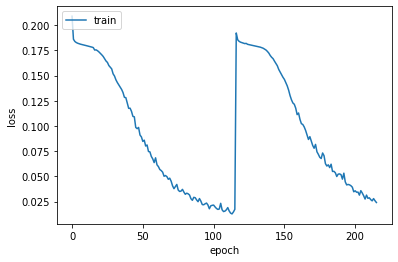

In [186]:
# 6. 학습과정 살펴보기
%matplotlib inline

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [187]:
# 7. 모델 평가하기
scores = model.evaluate(X_train, y_train, batch_size=1)
print("%s: %.2f" %(model.metrics_names[0], scores))
model.reset_states()

ValueError: ignored

# 모델 예상

In [424]:
test_steps = 100
start_steps = 10000
end_steps = start_steps + test_steps

In [385]:
X_test_time = X_test[start_steps:end_steps,:,5]
X_test_time

array([[Timestamp('2010-05-06 02:42:47.940000+0000', tz='UTC'),
        Timestamp('2010-05-09 05:59:41.620000+0000', tz='UTC'),
        Timestamp('2010-05-19 04:15:43.230000+0000', tz='UTC'),
        Timestamp('2010-05-19 10:30:10.400000+0000', tz='UTC'),
        Timestamp('2010-05-19 10:51:03.080000+0000', tz='UTC'),
        Timestamp('2010-05-23 22:46:52.050000+0000', tz='UTC'),
        Timestamp('2010-05-24 16:18:29.090000+0000', tz='UTC'),
        Timestamp('2010-05-25 10:09:05.780000+0000', tz='UTC'),
        Timestamp('2010-05-26 08:53:08.030000+0000', tz='UTC'),
        Timestamp('2010-05-27 17:14:46.570000+0000', tz='UTC')],
       [Timestamp('2010-05-09 05:59:41.620000+0000', tz='UTC'),
        Timestamp('2010-05-19 04:15:43.230000+0000', tz='UTC'),
        Timestamp('2010-05-19 10:30:10.400000+0000', tz='UTC'),
        Timestamp('2010-05-19 10:51:03.080000+0000', tz='UTC'),
        Timestamp('2010-05-23 22:46:52.050000+0000', tz='UTC'),
        Timestamp('2010-05-24 16:18:29.

In [386]:
X_test = np.reshape(X_test[start_steps:end_steps,:,:5],(test_steps,timesteps,5))
X_test

array([[[1.0, -18.058, -70.547, 37.0, 6.2],
        [3.0, 3.748, 96.018, 38.0, 7.2],
        [10.0, -5.083, -77.541, 132.0, 6.0],
        ...,
        [1.0, 35.336, -35.924, 10.0, 6.3],
        [1.0, 25.773, 129.944, 10.0, 6.5],
        [1.0, -13.698, 166.643, 31.0, 7.2]],

       [[3.0, 3.748, 96.018, 38.0, 7.2],
        [10.0, -5.083, -77.541, 132.0, 6.0],
        [0.0, -54.8, -135.252, 10.0, 6.0],
        ...,
        [1.0, 25.773, 129.944, 10.0, 6.5],
        [1.0, -13.698, 166.643, 31.0, 7.2],
        [0.0, -13.658, 166.745, 35.0, 6.1]],

       [[10.0, -5.083, -77.541, 132.0, 6.0],
        [0.0, -54.8, -135.252, 10.0, 6.0],
        [0.0, -54.843, -135.398, 10.0, 6.0],
        ...,
        [1.0, -13.698, 166.643, 31.0, 7.2],
        [0.0, -13.658, 166.745, 35.0, 6.1],
        [4.0, 6.948, 124.025, 20.0, 6.0]],

       ...,

       [[3.0, -26.803, -63.136, 576.8, 7.0],
        [1.0, -38.355, -73.326, 24.0, 7.2],
        [3.0, -22.26, 171.631, 112.2, 6.1],
        ...,
        [4.0,

In [437]:
y_test = np.reshape(y_test[start_steps:end_steps,:],(test_steps,5))
y_test = tf.cast(y_test, tf.float32)
y_test

<tf.Tensor: shape=(100, 5), dtype=float32, numpy=
array([[   0.   ,  -13.658,  166.745,   35.   ,    6.1  ],
       [   4.   ,    6.948,  124.025,   20.   ,    6.   ],
       [   0.   ,   11.132,   93.471,  112.   ,    6.5  ],
       [   1.   ,    9.331,  -84.206,   18.   ,    6.   ],
       [   8.   ,  -18.597,  169.485,   12.   ,    6.   ],
       [   3.   ,    7.881,   91.936,   35.   ,    7.5  ],
       [   4.   ,   -2.386,  136.635,   13.   ,    6.2  ],
       [   0.   ,   -2.174,  136.543,   18.   ,    7.   ],
       [   0.   ,   -2.329,  136.484,   10.5  ,    6.6  ],
       [   1.   ,  -33.168,  179.719,  170.4  ,    6.   ],
       [   1.   ,   44.448,  148.689,   28.   ,    6.2  ],
       [   6.   ,   -5.514,  151.161,   40.   ,    6.1  ],
       [   2.   ,  -10.627,  161.447,   35.   ,    6.7  ],
       [   4.   ,  -23.307,  179.116,  581.4  ,    6.4  ],
       [   0.   ,   16.396,  -97.782,   20.   ,    6.3  ],
       [   2.   ,  -13.643,  166.485,   29.   ,    6.3  ],
      

In [389]:
y_pred = np.array([])
for i in range(test_steps):
  y_pred = np.append(y_pred,model.predict(tf.convert_to_tensor(X_test[i].reshape(1,timesteps,5), dtype="float32"),verbose=0))
y_pred = tf.reshape(tf.convert_to_tensor(y_pred, dtype=tf.float32),[test_steps,5])
y_pred

<tf.Tensor: shape=(100, 5), dtype=float32, numpy=
array([[ 9.71589703e-03, -1.07338500e+00,  1.48365334e-01,
         1.75878052e-02, -1.87747881e-01],
       [ 5.83247421e-03, -7.60926783e-01, -1.60450742e-01,
         1.86266080e-02, -1.16335198e-01],
       [ 8.82251095e-03, -1.34307647e+00,  4.72136497e-01,
         1.01562748e-02, -1.50542557e-02],
       [ 2.65290821e-03, -5.48212305e-02, -6.30302668e-01,
         3.01957189e-04, -1.49777934e-01],
       [ 2.57090610e-02, -2.86614388e-01, -2.60270894e-01,
         6.46387562e-02,  9.32655811e-01],
       [ 5.03810635e-03, -6.32885754e-01,  1.45223284e+00,
         5.10438085e-02,  2.48559237e-01],
       [ 3.92076699e-03, -1.97082567e+00,  1.86350942e-02,
         1.88082212e-03, -5.34386635e-02],
       [ 4.18082578e-03, -1.20389283e+00,  1.33665562e+00,
         1.54882846e-02,  1.61434293e-01],
       [ 7.41493655e-03, -4.04734492e-01,  4.95951593e-01,
         5.34417341e-03, -9.75680500e-02],
       [ 4.39158781e-03, -8.3837

In [390]:
print(y_pred.dtype)
print(y_test.dtype)

<dtype: 'float32'>
<dtype: 'float32'>


In [391]:
y_error = []
for i in range(test_steps):
   y_error.append(custom_loss_function(tf.reshape(y_test[i,:],[1,5]),tf.reshape(y_pred[1,:],[1,5])).numpy()[0])
y_error

[1262.3861,
 452.6383,
 12583.617,
 362.63034,
 245.54341,
 1290.7771,
 224.7175,
 374.23508,
 155.33276,
 29068.246,
 824.52057,
 1673.1284,
 1274.8059,
 338063.56,
 440.8366,
 885.14575,
 773.2777,
 245.61981,
 13266.339,
 532.4489,
 258.59683,
 832.39056,
 1278.8453,
 137.73837,
 620.36926,
 10035.919,
 76.10717,
 368603.8,
 334122.1,
 410402.5,
 305834.72,
 381971.06,
 570.69745,
 1737.3523,
 399.39532,
 48435.594,
 770.51227,
 1985.0697,
 809.418,
 715.1354,
 42773.242,
 306.084,
 140.88638,
 213.9794,
 30555.865,
 138.06319,
 363867.75,
 145.07623,
 403.53806,
 155.4777,
 695.06476,
 194.57936,
 4798.148,
 131.24341,
 141.78766,
 296.30048,
 48541.586,
 1017.2626,
 148.49529,
 725.6843,
 1089.3978,
 418.79327,
 803.7371,
 14435.455,
 384.7629,
 482.32153,
 716.96967,
 167.04367,
 153.00676,
 361.99838,
 192.37823,
 258.66745,
 4664.224,
 220979.77,
 270.5269,
 1134.2389,
 940.44366,
 18502.145,
 18235.318,
 215.5162,
 252.98988,
 366.8202,
 367.48294,
 314.66968,
 207.34651,
 303

# 원래 데이터 포맷으로 돌리기

In [435]:
def reformTensorToEarthQuake(y_pred,inverse_transform=True):
    y_pred = pd.DataFrame(y_pred.numpy(),index=range(test_steps),columns = data.columns[:5])
    if inverse_transform:
        for column in data.columns[0:5]:
            y_pred.loc[:,[column]] = pipe.named_transformers_[column].inverse_transform(y_pred.loc[:,[column]])
    y_pred["time"] = X_test_time[:,-1].astype("datetime64[D]") + tf.math.round(y_pred["time"]).numpy().astype('timedelta64[D]')
    y_pred = y_pred.iloc[::-1]
    y_pred['time'] = y_pred['time'].astype(str)
    return y_pred

In [438]:
y_test = reformTensorToEarthQuake(y_test,False)

<ipython-input-435-487966ac9ff4>:6: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  y_pred["time"] = X_test_time[:,-1].astype("datetime64[D]") + tf.math.round(y_pred["time"]).numpy().astype('timedelta64[D]')


In [427]:
y_pred = reformTensorToEarthQuake(y_pred)

AttributeError: ignored

In [398]:
y_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 99 to 0
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       100 non-null    datetime64[ns]
 1   latitude   100 non-null    float32       
 2   longitude  100 non-null    float32       
 3   depth      100 non-null    float32       
 4   mag        100 non-null    float32       
 5   Date_str   100 non-null    object        
dtypes: datetime64[ns](1), float32(4), object(1)
memory usage: 3.3+ KB


# 데이터 시각화

In [404]:
def AddCircles(data,colormap,array):
  surfaceEnergy = np.multiply(10**(data['mag']*1.5),1/(data['depth']**2+1))
  minSurfaceEnergy = surfaceEnergy.min()

  for i, row in data.iterrows():
      borderRadius = np.power(10**(row['mag']*1.5)/minSurfaceEnergy - row['depth']**2,1/6)
      # np.sqrt(10**(row['mag']*1.5)/minSurfaceEnergy - row['depth']**2)
      color = colormap(row['mag'])
      latitude = row['latitude']
      if latitude > 90:
          latitude = 180 - latitude
      elif latitude < -90:
          latitude = - 180 - latitude
      feature = {
          'type': 'Feature',
          'geometry': {
              'type': 'Point',
              'coordinates': [row['longitude'], latitude]
          },
          'properties': {
              'time': row['time'],
              'style': {'color': color, 'radius': borderRadius},
              'icon': 'circle'
          }
      }
      array.append(feature)
      if row['longitude'] < 0 :
        feature = {
          'type': 'Feature',
          'geometry': {
              'type': 'Point',
              'coordinates': [row['longitude']+360, latitude]
          },
          'properties': {
              'time': row['time'],
              'style': {'color': color, 'radius': borderRadius},
              'icon': 'circle'
          }
      }
      array.append(feature)
  return array

In [440]:
def earthquakeVisualizer(realData,predData):
  

  m = folium.Map(location=[0, 90], zoom_start=2)

  realColormap = folium.LinearColormap(
      ['yellow', 'red','black'],
      vmin=realData['mag'].min(), vmax=realData['mag'].max()
  )
  m.add_child(realColormap)
  predColormap = folium.LinearColormap(
      ['green', 'blue','purple'],
      vmin=predData['mag'].min(), vmax=predData['mag'].max()
  )
  m.add_child(predColormap)

  # 지도 위에 시간 인터렉티브한 바 추가
  timestamps = data['time'].unique()
  features = []
  # minEnergy = 10**(data['mag'].min()*1.5)
  # distanceOfDeepestSixMagReachToOneKM = np.sqrt(data['depth'].max()**2+1)
  features = AddCircles(realData,realColormap,features)
  features = AddCircles(predData,predColormap,features)

  time_slider = plugins.TimestampedGeoJson({
      'type': 'FeatureCollection',
      'features': features
  }, period='P1D', add_last_point=True, auto_play=False, loop=False)

  m.add_child(time_slider)

  return m

In [441]:
earthquakeVisualizer(y_test,y_pred)

In [403]:
earthquakeVisualizer(data)